In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
    os.chdir(os.path.join(os.getcwd(), '..'))
    print(os.getcwd())
except:
    pass

/Users/mabucchi/com.github/pybalu/examples


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from multiprocessing import Pool
from pybalu.feature_extraction.geometric_utils import bbox as _bbox
from pybalu.feature_extraction import basic_geo_features
from pybalu.io import imread
from skimage.measure import label

In [3]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (7, 7)
matplotlib.rcParams["axes.titlesize"] = 20
matplotlib.rcParams["axes.titlepad"] = 15
del matplotlib

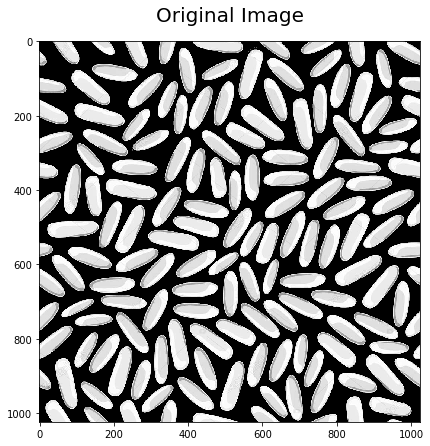

In [4]:
im = imread("feature_extraction/rice.png")
plt.title("Original Image", fontdict={"fontsize": 20}, pad=20)
plt.imshow(im, cmap="gray")
plt.show()

In [5]:
im_bin = (im > 140).astype(int)
labeled, n = label(im_bin, return_num=True)
labeled_T = labeled.T


def calc_ellipse(idx):
    region = (labeled_T == idx).astype(int)
    box = _bbox(region)
    feats = basic_geo_features(region[box])
    # feats[0]:  center of grav i [px]
    # feats[1]:  center of grav j [px]
    # feats[10]: MajorAxisLength  [px]
    # feats[11]: MinorAxisLength  [px]
    # feats[12]: Orientation      [deg]
    return np.array([box[0].start + feats[0], box[1].start + feats[1], feats[10], feats[11], feats[12]])


with Pool() as pool:
    ellipses = np.vstack(pool.map(calc_ellipse, range(1, n)))

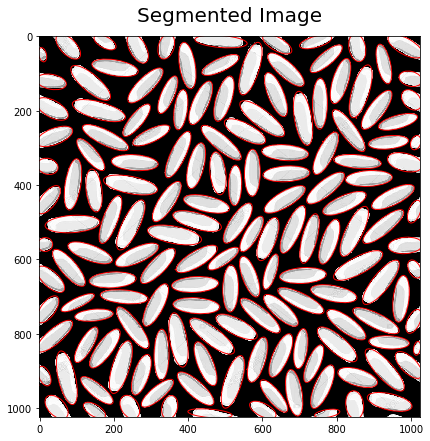

In [6]:
ax = plt.axes()
plt.title("Segmented Image")
plt.imshow(im, cmap="gray")


def draw_ellipse(x, y, height, width, angle, axes):
    ell = Ellipse(xy=(x, y), height=height, width=width,
                  angle=angle, edgecolor="red", facecolor="none")
    axes.add_artist(ell)
    ell.set_clip_box(axes.bbox)
    return ell


for ell in ellipses:
    draw_ellipse(*ell, axes=ax)

plt.show()

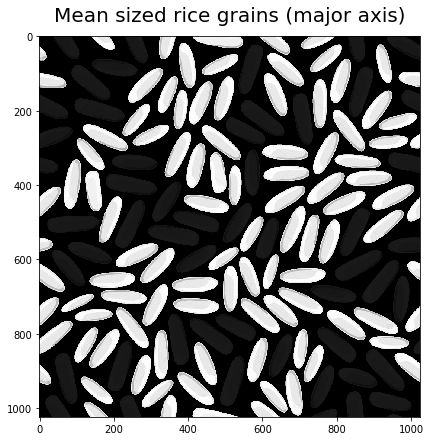

In [7]:
plt.title("Mean sized rice grains (major axis)")

major_25 = np.percentile(ellipses[:, 3], 25)
major_75 = np.percentile(ellipses[:, 3], 75)

valid_labels = 1 + \
    np.where((ellipses[:, 3] > major_25) & (ellipses[:, 3] < major_75))[0]
im_mean = np.array(im)
im_mean[np.where(~np.isin(labeled, valid_labels))] //= 7
plt.imshow(im_mean, cmap="gray")
plt.show()

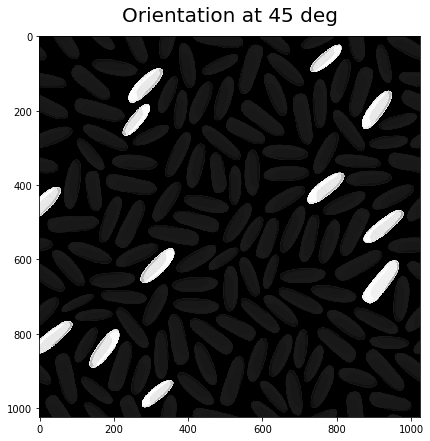

In [8]:
def draw_at_angle(theta):
    valid_labels = 1 + \
        np.where((ellipses[:, 4] > theta - 10) &
                 (ellipses[:, 4] < theta + 10))[0]
    plt.title(f"Orientation at {theta} deg")
    im_rotated = np.array(im)
    im_rotated[np.where(~np.isin(labeled, valid_labels))] //= 7
    plt.imshow(im_rotated, cmap="gray")
    plt.show()


draw_at_angle(45)